In [23]:
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
%matplotlib inline
from learning_plasticity import data_loader
from learning_plasticity import BCM_fully_connect_cl as BCM
# Reset tf.app.flags.FLAGS
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()

from tensorflow.python.framework import ops
ops.reset_default_graph()


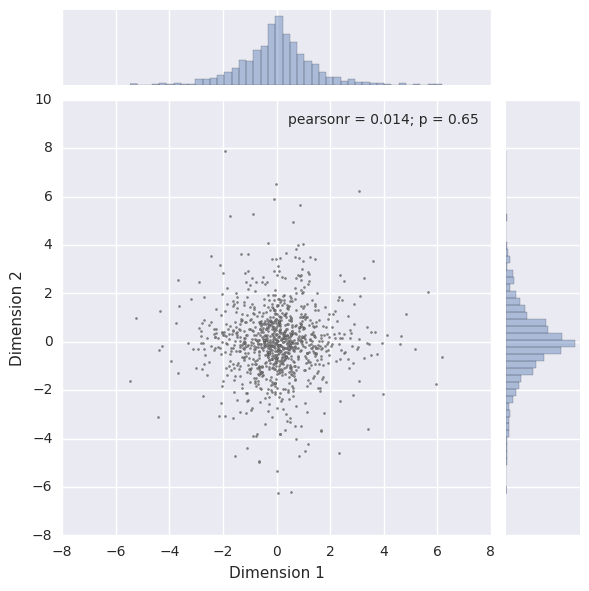

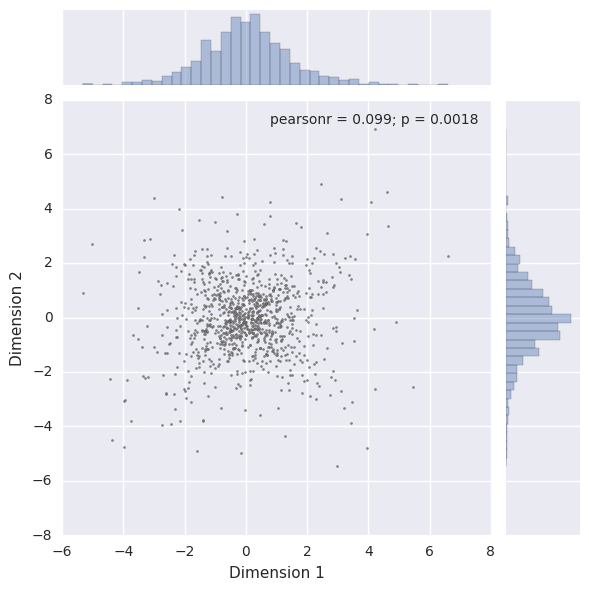

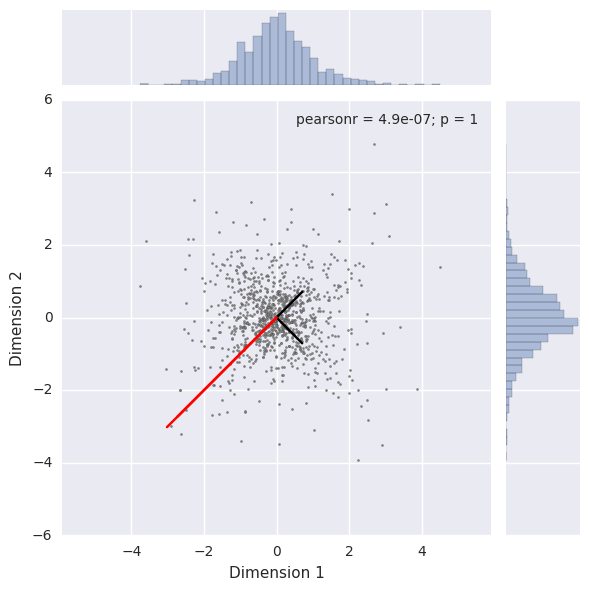

In [24]:
# data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = True, iffigure = False)
data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = True, iffigure = True)# Direct running of BCM in tf

dim_x = 2
n_output = 2
eta = 0.0005
decay = 0.01
p = 2
tau = 200
epoch = 100


sample_size = data.shape[0]

# Give input place holder

input_value = tf.placeholder(tf.float32, [1, dim_x])
obj_input = tf.placeholder(tf.float32, [sample_size, dim_x])

# Varaible
w = tf.Variable(tf.random_normal([dim_x, n_output]))
#w = tf.Variable(tf.zeros([dim_x, n_output])+0.2)
threshold = tf.Variable(tf.zeros([1, n_output]))

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
output_value = tf.nn.relu(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
delta_w = eta * tf.matmul(input_value, tf.mul(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.exp(-1/tau)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.pow(obj2, 2)/4

# Train the model

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
for i in range(epoch):
    tf.random_shuffle(data)
    for j in range(data.shape[0]):
        # print(data[j,:])
        sess.run(update_w, feed_dict = {input_value: data[j,:].reshape(1,2)})
        sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,2)})
        sess.run(obj, feed_dict = {obj_input: data})
        w_track.append(sess.run(w).reshape(1,4))
        thres_track.append(sess.run(threshold))

# Plot the final weight
final_w = sess.run(w).reshape(1,4)
plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'k')
plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'k')
g = plt.gca()
g.set_aspect(1)
plt.plot([0, final_w[0][0]], [0, final_w[0][1]], 'r')
plt.plot([0, final_w[0][2]], [0, final_w[0][3]], 'r')